In [40]:
#!pip install pandas
#!pip install sqlalchemy
#!pip install matplotlib
#!pip install numpy

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import json
import ast
from db_connection import engine 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Import the data 
query = "SELECT * FROM line_items"

line_items = pd.read_sql_query(query, engine)
line_items.head()

,id,transaction_id,details
0,05275e2c-6096-40a5-b440-2ca233661dd8,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,"{'name': 'Lightweight Rubber Pants', 'quantity..."
1,55f1315f-5ab7-4130-994f-a54a66a23088,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,"{'name': 'Jean Poole', 'quantity': 9, 'total_p..."
2,c26d878e-6bfb-4de3-8da3-510854900138,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Heavy Duty Cotton Knife', 'quantity'..."
3,02d8224e-0208-4ca3-aa0b-bbfb34424c62,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Incredible Rubber Shoes', 'quantity'..."
4,b2015611-9985-4e4e-8eb3-c953d764d21a,5706cb41-2877-4d76-ac7d-caf63d951328,"{'name': 'Marcus Absent', 'quantity': 5, 'tota..."


In [3]:
# Normalize the 'details' column
details_df = pd.json_normalize(line_items['details'])

# Concatenate the line_items with the normalized details DataFrame
line_items = pd.concat([line_items.drop(columns=['details']), details_df], axis=1)

line_items.head()

,id,transaction_id,name,quantity,total_price
0,05275e2c-6096-40a5-b440-2ca233661dd8,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,Lightweight Rubber Pants,4,110.35
1,55f1315f-5ab7-4130-994f-a54a66a23088,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,Jean Poole,9,878.56
2,c26d878e-6bfb-4de3-8da3-510854900138,5706cb41-2877-4d76-ac7d-caf63d951328,Heavy Duty Cotton Knife,9,400.61
3,02d8224e-0208-4ca3-aa0b-bbfb34424c62,5706cb41-2877-4d76-ac7d-caf63d951328,Incredible Rubber Shoes,2,329.62
4,b2015611-9985-4e4e-8eb3-c953d764d21a,5706cb41-2877-4d76-ac7d-caf63d951328,Marcus Absent,5,159.43


* Transactions are ID is unique primary key
* Details of transactions will need to expanded for exploratory work
* Name appears to be the actual product, quantity is the number ordered, total_price was the price for quantity * product price
* Stakeholder wants to know - Analyse the basket size of transactions to give insights on amounts spent by customer over time.
     - Explore Type of products, average price
     - Basket size (require looking a the sum of transactions) - Number of products, average basket size, 
     - popularity of product 
     - Time line if we combine the transactions table we may gain insist on forecasting  future sales or trends (Seasonal,TimeSeries)

In [4]:
#Understand the Range for entries in the line_items, this would be essentially the name. 
line_items.describe()

,quantity,total_price
count,454054.000000,454054.000000
mean,4.995093,170.868117
std,2.581428,214.148408
min,1.000000,0.010000
25%,3.000000,18.080000
50%,5.000000,79.330000
75%,7.000000,245.700000
max,9.000000,1999.070000


In [5]:
#Understand how many names are in the file
line_items.nunique() 

id                454054
transaction_id    152665
name                6530
quantity               9
total_price        75802
dtype: int64

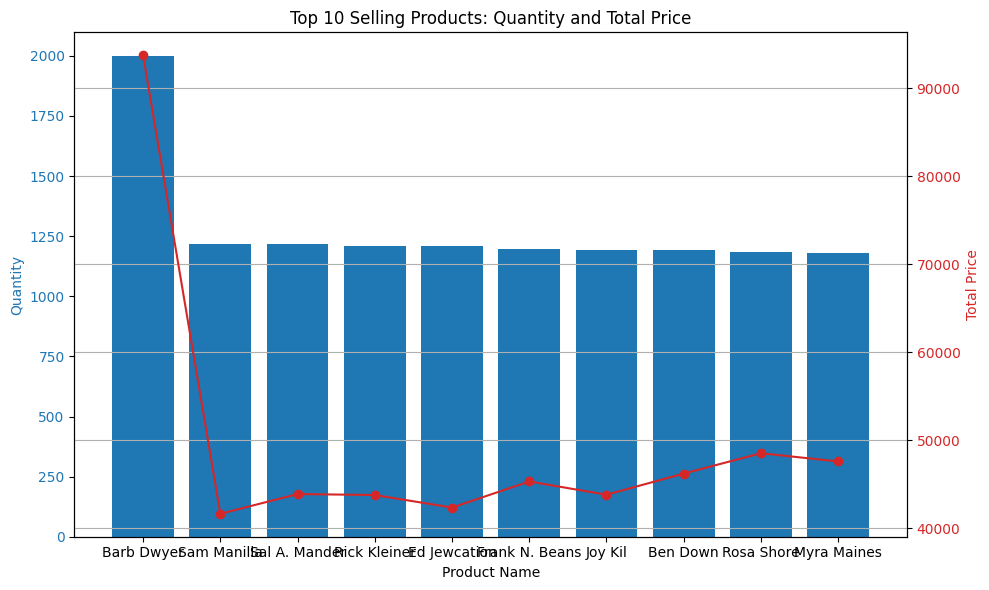

In [6]:
# Group by product name and calculate sum of quantity and total price
grouped_data = line_items.groupby('name').agg({'quantity': 'sum', 'total_price': 'sum'}).reset_index()

# Sort by quantity in descending order and select top 10
top_10_products = grouped_data.nlargest(10, 'quantity')

# Plotting the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for quantity
color = 'tab:blue'
ax1.bar(top_10_products['name'], top_10_products['quantity'], color=color, label='Sum of Quantity')
ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for total price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(top_10_products['name'], top_10_products['total_price'], color=color, marker='o', label='Sum of Total Price')
ax2.set_ylabel('Total Price', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Top 10 Selling Products: Quantity and Total Price')
fig.tight_layout()
plt.grid(True)
plt.show()


* When looking at the head() it appeared that name was the type of product however when selecting the top 10  the names appear to be actual people names... clarity on the data will be needed. 
* Per transaction, large variance total price and quantity ordered with some outliers. 

In [7]:
# Group by transaction_id and calculate average basket quantity and value
basket_data = line_items.groupby('transaction_id').agg({'quantity': 'sum', 'total_price': 'sum'}).reset_index()

basket_data.describe()

,quantity,total_price
count,152665.000000,152665.000000
mean,14.856332,508.193442
std,8.256824,292.529357
min,1.000000,10.010000
25%,8.000000,257.560000
50%,14.000000,506.990000
75%,21.000000,754.770000
max,44.000000,1999.070000


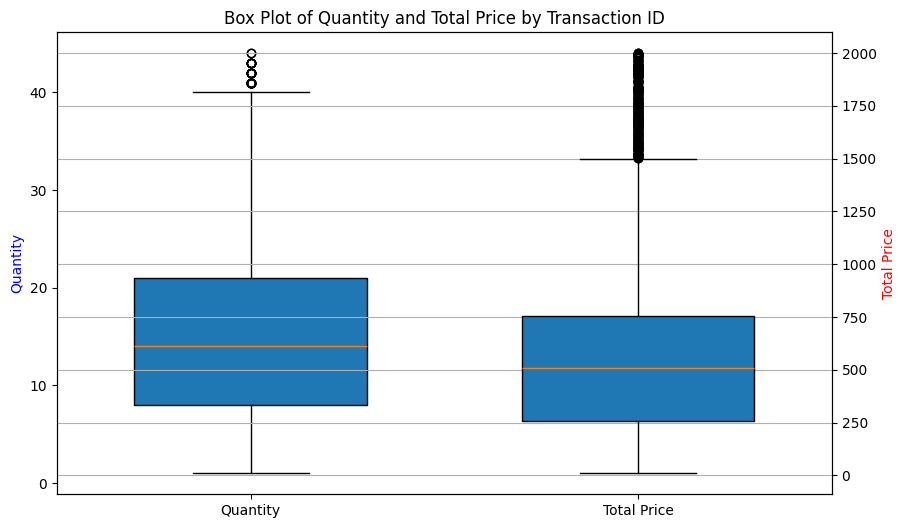

In [10]:
# Understanding the normality of basket size 

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Define box plot positions
box_positions = [1, 2]

# Plot box plot for 'quantity'
ax.boxplot(basket_data['quantity'], positions=[box_positions[0]], patch_artist=True, widths=0.6)
ax.set_ylabel('Quantity', color='blue')

# Create another y-axis for 'total_price'
ax2 = ax.twinx()
ax2.boxplot(basket_data['total_price'], positions=[box_positions[1]], patch_artist=True, widths=0.6)
ax2.set_ylabel('Total Price', color='red')

# Set x-axis ticks and labels
plt.xticks(box_positions, ['Quantity', 'Total Price'])

# Show grid
plt.grid(True)

plt.title('Box Plot of Quantity and Total Price by Transaction ID')
plt.show()

In [14]:
#Import the data 
# assumptions that line_items and transactions are in the same currency despite no currency given in the jsonarray, I will convert the transaction amount and
query = """
 SELECT id as transaction_id,
        t.booked_time::date as purchase_date,
        t.client_name, 
        revenue,
        currency,
        COALESCE(rate * revenue, revenue) as eur_revenue
FROM transactions as t
LEFT JOIN exchange_rates as ex
ON ex.date =  t.booked_time::date
AND ex.buy_currency = 'EUR'
AND ex.sell_currency = currency """


transactions = pd.read_sql_query(query, engine)
transactions.head()

,transaction_id,purchase_date,client_name,revenue,currency,eur_revenue
0,e3ba488a-2419-4c3b-9c3c-6f8f559f0ed5,2022-01-30,Jast and Sons,1.75,GBP,1.985064
1,5706cb41-2877-4d76-ac7d-caf63d951328,2022-02-28,Jast and Sons,8.60,EUR,8.600000
2,b8eb5eff-ff22-457a-a030-be0967f853ed,2022-03-18,Rice-Grady,9.29,EUR,9.290000
3,270962fa-95e6-43a5-84d7-6bad8340e58f,2022-03-01,Rice-Grady,0.48,EUR,0.480000
4,fc04e028-935c-41f1-84de-691bd1e21498,2022-05-09,Jast and Sons,1.10,GBP,1.271634


In [19]:
# There is only 5 client names 
transactions.nunique()

transaction_id    152665
purchase_date        539
client_name            5
revenue             1180
currency               4
eur_revenue        99633
dtype: int64

In [17]:
# Join with line_items for analysis 

combined_data = pd.merge(basket_data, transactions, on='transaction_id', how='outer')
combined_data.head()

,transaction_id,quantity,total_price,purchase_date,client_name,revenue,currency,eur_revenue
0,0000b61e-eefd-4e54-a398-a8c3936b97a1,8,185.16,2023-11-17,Rice-Grady,0.52,SEK,0.045647
1,0001bb29-3de8-450f-84ff-eedc841cdcab,16,975.96,2023-07-21,Kulas-Barton,1.98,SEK,0.173513
2,0002fc13-875f-4221-bef8-979eb18c2cda,6,501.64,2023-11-15,Kulas-Barton,3.67,GBP,4.201768
3,00031d2a-8f96-4703-b0eb-d7dc72b24f72,10,159.08,2023-09-10,Kulas-Barton,0.34,GBP,0.383373
4,000355ec-59e5-47a5-a5ee-e8077dff8697,11,447.16,2023-03-19,Emmerich LLC,2.33,GBP,2.659639


In [21]:
# What are the % we are getting from each client_name
combined_data['client_percentage'] =  combined_data['revenue']/combined_data['total_price']*100
combined_data.head()

,transaction_id,quantity,total_price,purchase_date,client_name,revenue,currency,eur_revenue,client_percentage
0,0000b61e-eefd-4e54-a398-a8c3936b97a1,8,185.16,2023-11-17,Rice-Grady,0.52,SEK,0.045647,0.280838
1,0001bb29-3de8-450f-84ff-eedc841cdcab,16,975.96,2023-07-21,Kulas-Barton,1.98,SEK,0.173513,0.202877
2,0002fc13-875f-4221-bef8-979eb18c2cda,6,501.64,2023-11-15,Kulas-Barton,3.67,GBP,4.201768,0.731600
3,00031d2a-8f96-4703-b0eb-d7dc72b24f72,10,159.08,2023-09-10,Kulas-Barton,0.34,GBP,0.383373,0.213729
4,000355ec-59e5-47a5-a5ee-e8077dff8697,11,447.16,2023-03-19,Emmerich LLC,2.33,GBP,2.659639,0.521066


In [36]:
# Convert the total_price to Eur usign the client_percentage, this is under the assumption the json was not already in Euros

combined_data['total_price_eur'] = combined_data['eur_revenue']/(combined_data['client_percentage']/100)
combined_data.head()

,transaction_id,quantity,total_price,purchase_date,client_name,revenue,currency,eur_revenue,client_percentage,month,total_price_eur
0,0000b61e-eefd-4e54-a398-a8c3936b97a1,8,185.16,2023-11-17,Rice-Grady,0.52,SEK,0.045647,0.280838,2023-11,16.253715
1,0001bb29-3de8-450f-84ff-eedc841cdcab,16,975.96,2023-07-21,Kulas-Barton,1.98,SEK,0.173513,0.202877,2023-07,85.526303
2,0002fc13-875f-4221-bef8-979eb18c2cda,6,501.64,2023-11-15,Kulas-Barton,3.67,GBP,4.201768,0.731600,2023-11,574.325629
3,00031d2a-8f96-4703-b0eb-d7dc72b24f72,10,159.08,2023-09-10,Kulas-Barton,0.34,GBP,0.383373,0.213729,2023-09,179.373358
4,000355ec-59e5-47a5-a5ee-e8077dff8697,11,447.16,2023-03-19,Emmerich LLC,2.33,GBP,2.659639,0.521066,2023-03,510.422408


In [22]:
combined_data.describe()

,quantity,total_price,revenue,eur_revenue,client_percentage
count,152665.000000,152665.000000,152665.000000,152665.000000,152665.000000
mean,14.856332,508.193442,2.794760,1.663062,0.550092
std,8.256824,292.529357,2.218194,2.178432,0.259946
min,1.000000,10.010000,0.010000,0.000874,0.067889
25%,8.000000,257.560000,1.000000,0.214612,0.324920
50%,14.000000,506.990000,2.210000,0.611624,0.550343
75%,21.000000,754.770000,4.140000,2.390000,0.775109
max,44.000000,1999.070000,19.100000,21.750376,1.017812


/var/folders/dk/psx0q4qx07x65m41mmwmgj1c0000gp/T/ipykernel_94893/3040972046.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group.values for name, group in grouped_data], labels=grouped_data.groups.keys(), patch_artist=True)


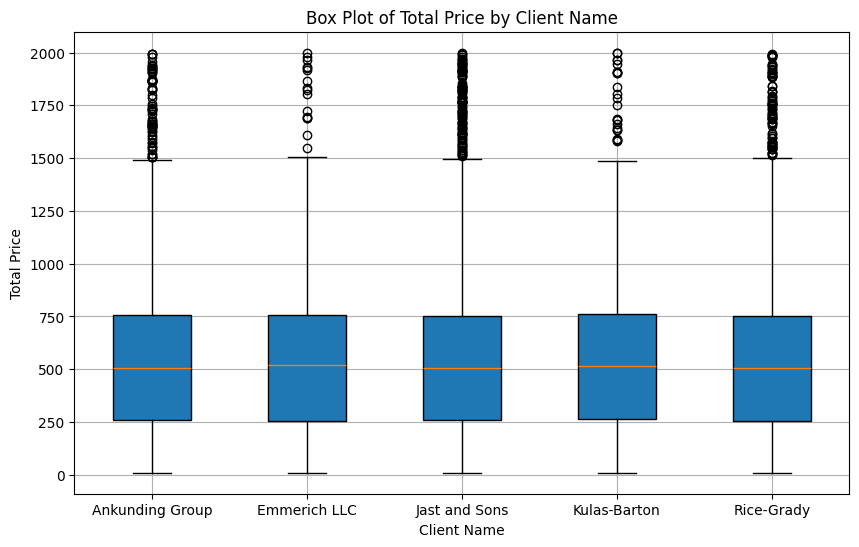

In [23]:
# Basket size per client
# Group data by client_name
grouped_data = combined_data.groupby('client_name')['total_price']

# Create a box plot for each group
plt.figure(figsize=(10, 6))
plt.boxplot([group.values for name, group in grouped_data], labels=grouped_data.groups.keys(), patch_artist=True)

# Customize the plot
plt.title('Box Plot of Total Price by Client Name')
plt.xlabel('Client Name')
plt.ylabel('Total Price')
plt.grid(True)
plt.show()

There is a decent amount of long tail for each client. It would be conducive to view over time to see if the amount they are spending is increasing over time. Given a business model of they borrow and then grow more this would be an expected behavior as each new growth would like cost more. 

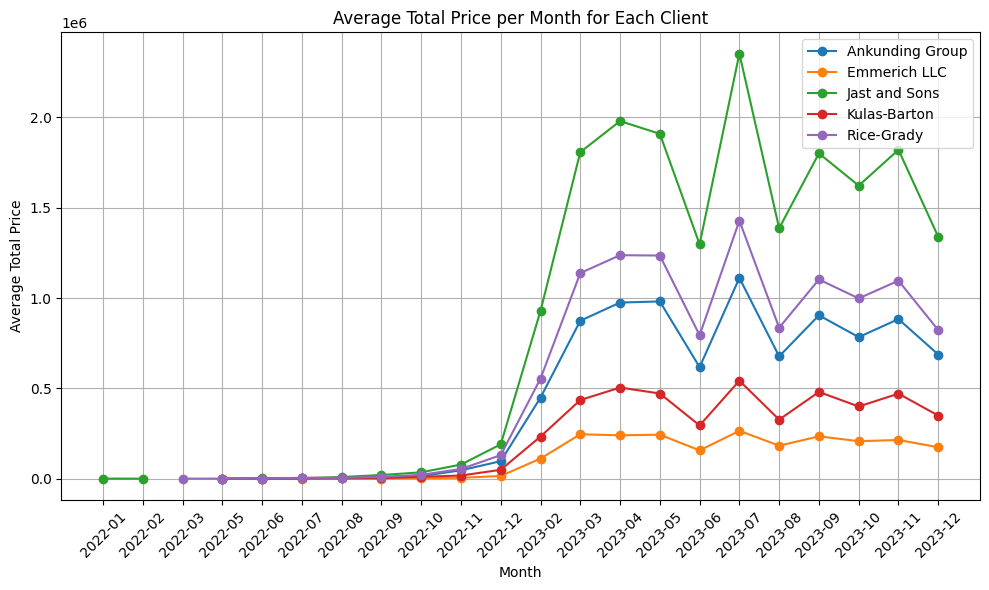

In [37]:
# How does this look for each client over time? 

# Convert purchase_date to datetime
combined_data['purchase_date'] = pd.to_datetime(combined_data['purchase_date'])

# Group data by month and client_name, then calculate the average total_price for each month and each client
combined_data['month'] = combined_data['purchase_date'].dt.to_period('M')
average_price_per_month_per_client = combined_data.groupby(['month', 'client_name'])['total_price_eur'].sum().unstack()
# Convert PeriodIndex to string for plotting
average_price_per_month_per_client.index = average_price_per_month_per_client.index.strftime('%Y-%m')



# Plot the average total price per month for each client
plt.figure(figsize=(10, 6))
for client_name in average_price_per_month_per_client.columns:
    plt.plot(average_price_per_month_per_client.index, average_price_per_month_per_client[client_name], marker='o', linestyle='-', label=client_name)

# Customize the plot
plt.title('Average Total Price per Month for Each Client')
plt.xlabel('Month')
plt.ylabel('Average Total Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


In [39]:
average_price_per_month_per_client.describe()

client_name,Ankunding Group,Emmerich LLC,Jast and Sons,Kulas-Barton,Rice-Grady
count,19.000000,19.000000,21.000000,19.000000,20.000000
mean,316.410563,308.740885,413.158633,375.598767,362.471126
std,156.696679,118.299730,240.108878,214.186471,152.047268
min,24.700318,34.331629,231.222951,69.065764,230.249006
25%,267.455085,294.798360,300.512894,295.393527,292.777607
50%,296.555279,307.224073,301.780995,301.641219,300.773923
75%,303.199329,321.625523,362.561167,360.990432,328.610806
max,723.261701,600.612057,1121.742369,955.674472,786.202296


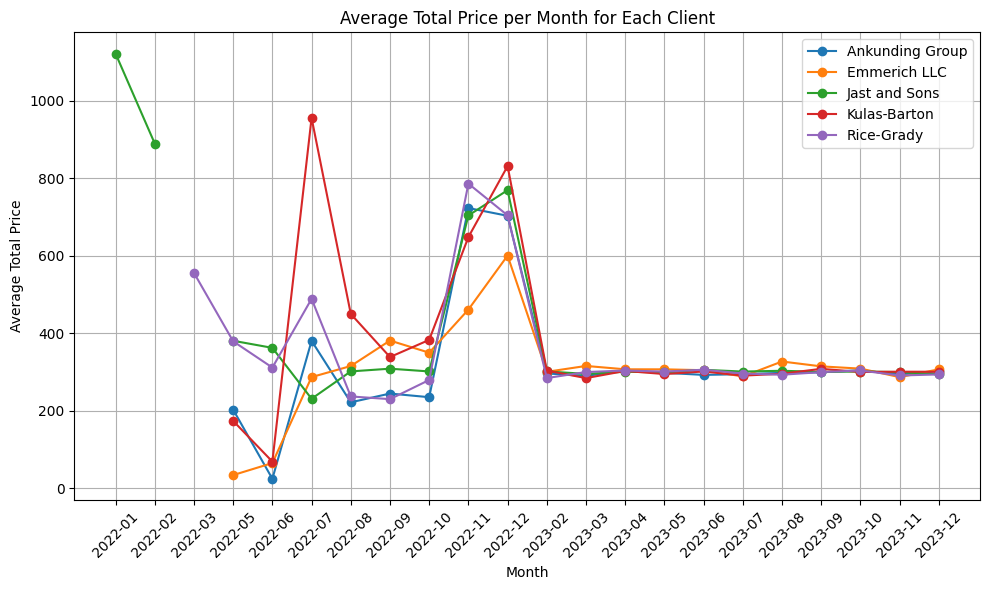

In [38]:

# Convert purchase_date to datetime
combined_data['purchase_date'] = pd.to_datetime(combined_data['purchase_date'])

# Group data by month and client_name, then calculate the average total_price for each month and each client
combined_data['month'] = combined_data['purchase_date'].dt.to_period('M')
average_price_per_month_per_client = combined_data.groupby(['month', 'client_name'])['total_price_eur'].mean().unstack()

# Convert PeriodIndex to string for plotting
average_price_per_month_per_client.index = average_price_per_month_per_client.index.strftime('%Y-%m')

# Plot the average total price per month for each client
plt.figure(figsize=(10, 6))
for client_name in average_price_per_month_per_client.columns:
    plt.plot(average_price_per_month_per_client.index, average_price_per_month_per_client[client_name], marker='o', linestyle='-', label=client_name)

# Customize the plot
plt.title('Average Total Price per Month for Each Client')
plt.xlabel('Month')
plt.ylabel('Average Total Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()